In [1]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

model1 = VGG16(
    weights='imagenet'
)
model1.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

img_fpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/creative_commons_elephant.jpg'

img = image.load_img(
    img_fpath,
    target_size=(224, 224)
)

img_arr = image.img_to_array(img)
print('Original Shape:', img_arr.shape)

img_arr = np.expand_dims(img_arr, axis=0)
print('New1 Shape:', img_arr.shape)

img_arr = preprocess_input(img_arr) # preprocess_input: VGG16의 Input에 잘 적용되도록 적절히 변환해주는 것임!
print('New2 Shape:', img_arr.shape)

Original Shape: (224, 224, 3)
New1 Shape: (1, 224, 224, 3)
New2 Shape: (1, 224, 224, 3)


In [4]:
img_pred = model1.predict(img_arr)

print('Predicted:')
for each in decode_predictions(img_pred, top=5)[0]:
    print(each)

Predicted:
40960/35363 [==================================] - 0s 0us/step
('n02504458', 'African_elephant', 0.90942174)
('n01871265', 'tusker', 0.086182125)
('n02504013', 'Indian_elephant', 0.004354569)
('n02408429', 'water_buffalo', 3.9944192e-05)
('n02397096', 'warthog', 1.3171737e-06)


In [5]:
print(np.argmax(img_pred[0]))

386


In [6]:
# 386번째 index의 확률을 찾아보자.
print(img_pred[0][386])

0.90942174


* Grad-CAM 시작!
* Notice: Prof said, 아래의 코드는 **K.gradients** 문제 때문에 실행이 안되니, 아래의 User Defined Function을 그냥 쓰도록 하자!

In [ ]:
from tensorflow.keras import backend as K

AfricanElephant_output = model1.output[:, 386] # max softmax 값을 가졌던 output만을 가져온다.

LastConvLayer = model1.get_layer('block5_conv3') # Pooling을 제외한, 가장 끝단에 있는 Convolutional Layer를 지정한다.

gradient_arr = K.gradients(AfricanElephant_output, LastConvLayer.output)[0]

gradientmean_arr = K.mean(gradient_arr, axis=(0, 1, 2))

iterate = K.funciton([model1.input], [gradient_mean, LastConvLayer.output[0]])

gradient_mean, ConvLayer_output = iterate([img_arr])

for i in range(512): # 가장 끝단에 있는 Convolutional Layer의 Output Shape의 가장 마지막 값이 512임!
    ConvLayer_output[:, :, i] *= gradient_mean[i]

heatmap_arr = np.mean(ConvLayer_output, axis=-1)

print(heatmap_arr.shape)

RuntimeError: ignored

In [7]:
import tensorflow as tf
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [8]:
heatmap_arr = make_gradcam_heatmap(img_arr, model1, 'block5_conv3')

print(heatmap_arr.shape)

(14, 14)


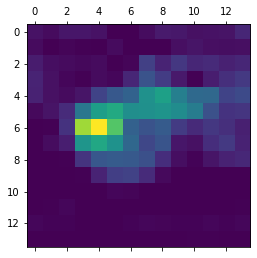

''

In [9]:
import matplotlib.pyplot as plt

heatmap_arr = np.maximum(heatmap_arr, 0)
heatmap_arr = heatmap_arr / np.max(heatmap_arr)
plt.matshow(heatmap_arr)
plt.show()
;

* 위의 size가 14 X 14 밖에 안되므로, 좀 더 늘리기 위해, 아래의 openCV 코드를 사용한다.

In [ ]:
! pip install opencv-python

In [ ]:
import cv2
img_arr = cv2.imread(img_fpath)

heatmap_arr = cv2.resize(heatmap_arr,
                         (img_arr.shape[1], img_arr.shape[0]))

heatmap_arr = np.uint8(255 * heatmap_arr)

heatmap_arr = cv2.applyColorMap(heatmap_arr, cv2.COLORMAP_JET)

SuperImposed_img = heatmap_arr * 0.4 + img_arr

cv2.imwrite('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/elephant_cam.jpg', 
            SuperImposed_img)

True

* Now, 저장된 파일을 직접 열어서 확인해보자!